In [16]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from phe import pickle, query, download, plot_summary

In [18]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2020-12-25,2020-12-23,United Kingdom,K02000001,NaN,NaN,NaN,507384.0
1,2020-12-25,2020-12-22,United Kingdom,K02000001,28019.0,NaN,415.0,453903.0
2,2020-12-25,2020-12-21,United Kingdom,K02000001,41471.0,NaN,495.0,423675.0
3,2020-12-25,2020-12-20,United Kingdom,K02000001,31864.0,2143.0,424.0,433470.0
4,2020-12-25,2020-12-19,United Kingdom,K02000001,24959.0,2006.0,412.0,440584.0
...,...,...,...,...,...,...,...,...
343,2020-12-25,2020-01-15,United Kingdom,K02000001,0.0,NaN,NaN,NaN
344,2020-12-25,2020-01-14,United Kingdom,K02000001,0.0,NaN,NaN,NaN
345,2020-12-25,2020-01-13,United Kingdom,K02000001,0.0,NaN,NaN,NaN
346,2020-12-25,2020-01-12,United Kingdom,K02000001,0.0,NaN,NaN,NaN


In [19]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England')

PosixPath('/Users/chris/Downloads/england_2020-12-25.csv')

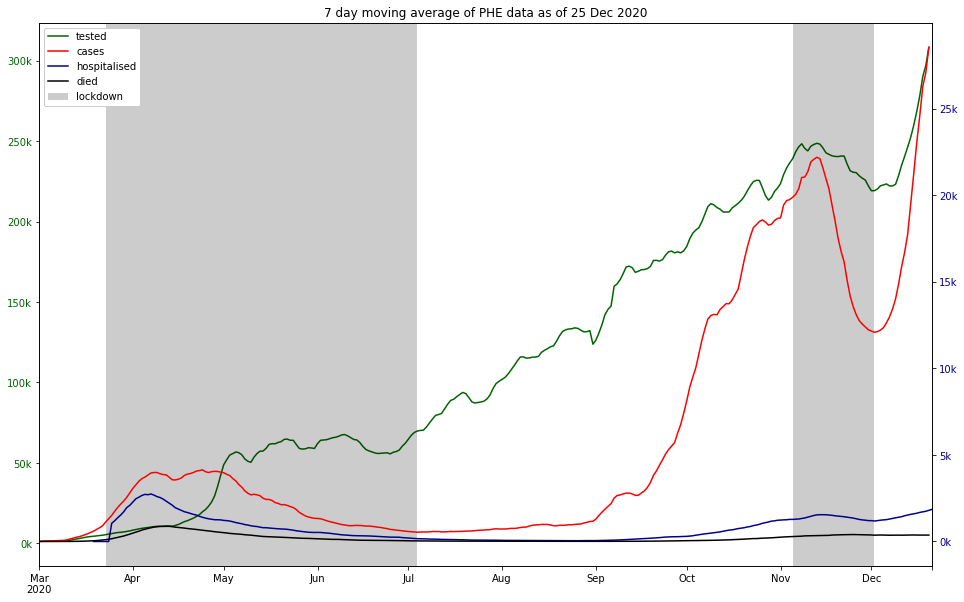

In [20]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [21]:
download('region', 'region', new_cases_by_specimen_date, new_deaths_by_death_date, 
         unique_people_tested_sum,  unique_cases_positivity_sum, new_cases_rate)

PosixPath('/Users/chris/Downloads/region_2020-12-25.csv')

In [22]:
download(ltla, ltla, new_cases_by_specimen_date, new_deaths_by_death_date, 
         unique_people_tested_sum,  unique_cases_positivity_sum, new_cases_rate)

PosixPath('/Users/chris/Downloads/ltla_2020-12-25.csv')

In [23]:
download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change)

PosixPath('/Users/chris/Downloads/msoa_2020-12-25.csv')